# Lab 3: Introduction to Mining Matrix Data

In this lab, we will be focusing on **Dimensionality Reduction**. As discussed in lecture, Dimensionality Reduction can help us uncover insights by allowing us to "zoom" in on the important features in our data and discover hidden patterns. To show the power of this technique, we will be implementing a use case in which we will will apply **Latent Semantic Analysis (LSA)** to tweets about the H1N1 pandemic/vaccine. We can think of LSA as applying Singular Value Decomposition (SVD) to a Document x Term matrix. Then, we will shift our attention to recommender systems - we will apply SVD to a User x Movies dataset to find user-factors and movie-factors and will implement a simple recommender system using a clustering approach.

In [50]:
import json
import random
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import spatial

### 1.  LSA on H1N1 Twitter Data

The first task is to leverage Twitter Data to gain insights into the evolution of vaccine acceptance during the H1N1 pandemic. As evident with our recent experiences with COVID-19, there is an increased sense of urgency to develop and distribute vaccines rapidly during pandemics. As such, H1N1 offers an interesting perspective as the H1N1 vaccine was developed in a very short period of time.

Instead of looking at and comparing all of the H1N1 pandemic milestones (see below for a timeline of the milestones), we will focus in on just two of them:

1) Milestone 1 - April 15: first human infection in California

2) Milestone 5 - September 15: FDA announces approval of 4 H1N1 vaccines

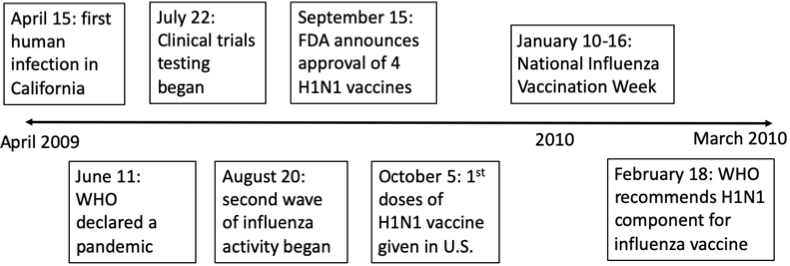

To complete this analysis, we must complete the following stelps:

* **Step 1**: Use the Twitter API to retrieve ~500 tweets for each milestone

    * Query definition: (H1N1 OR swine flu) AND (vaccine*), no retweets, only English tweets
    * **This step is already completed for you**  - you will just have to read in the tweet data from json files
    

* **Step 2**: Explore and clean the tweets (e.g., remove links, stop words and numbers)


* **Step 3**: Apply TFIDFVectorizer to obtain the document-term matrix


* **Step 4**: Apply TruncatedSVD to get the topics for each milestone

#### 1.1 Load the Tweets Data

In [5]:
# we will load and analyze tweets from the two milestones separately
# tweets1 will refer to tweets from the 1st H1N1 milestone - 1st human infection in California
# tweets5 will refer to tweets from the 5th H1N1 milestone - FDA announces approval of 4 H1N1 vaccines

with open('tweets_time1.json', 'r') as f:
    tweets1 = json.load(f)
    
print("Milestone 1 - Number of Tweets:", len(tweets1))
    
with open('tweets_time5.json', 'r') as f:
    tweets5 = json.load(f)
    
print("Milestone 5 - Number of Tweets:", len(tweets5))

Milestone 1 - Number of Tweets: 541
Milestone 5 - Number of Tweets: 500


In [6]:
# example tweet object
# each tweet is stored with a unique id as the key and has the following attributes:
# (1) timestamp
# (2) text (this will be our focus)

tweets1['1598228282']

{'timestamp': 'Thu Apr 23 22:12:33 +0000 2009',
 'text': 'CDC: rare swine flu detected in 7 Americans. Still unknown if vaccine is available to protect against the strain. http://tinyurl.com/cksqp4'}

#### 1.2 Explore and Clean Tweets

The first step will be to check for duplicate tweets in our data and remove them as necessary. This is important as we want to get a good distribution of the topics being discussed from the milestones and do not want them to be biased by duplicate tweets. 

In [51]:
# check for and remove any duplicates

# source: https://www.w3schools.com/python/python_howto_remove_duplicates.asp
def remove_dups(x):
    return list(dict.fromkeys(x))

tweets1_no_dups = []
tweets1_text = [tweets1[tweet]["text"] for tweet in tweets1] # extract the text from the tweet object
tweets1_no_dups = remove_dups(tweets1_text)
print("Before:", len(tweets1), "After:", len(tweets1_no_dups))

tweets5_no_dups = []
tweets5_text = [tweets5[tweet]["text"] for tweet in tweets5] # extract the text from the tweet object
tweets5_no_dups = remove_dups(tweets5_text)
print("Before:", len(tweets5), "After:", len(tweets5_no_dups))

Before: 541 After: 527
Before: 500 After: 462


Note: we still may see substantial overlap in the content of some tweets; for example, tweets may refer to the same article by its title but we will no longer have tweets with the same *exact* content. Next, to famialize ourselves with the data, let's look at some example tweets from each milestone.

In [52]:
print("Sample Tweets for Milestone 1")
print(random.sample(tweets1_no_dups, 10))
print("-------------------------------------------------------------------------------------------------------------")
print("Sample Tweets for Milestone 5")
print(random.sample(tweets5_no_dups, 10))

Sample Tweets for Milestone 1
['Swine Flu Special Report, Vaccines, Treatments, Prevention, Cases, www.BallerinaDaily.com/wordpress', "@CarlWeaver I don't suppose that swine flu vaccination I got in 1976 is going to help me much. (There are actually cases here in SoCal.)", 'Drug and vaccine makers on standby over swine flu http://r.reuters.com/bup54c', '#celeb #gossip Swine Flu Pandemic with No Vaccine: \nA hybrid swine flu virus, aka influenza, conta.. http://tinyurl.com/d72cjm', 'More people died from the Swine Flu vaccine than from Swine Flu in 1976 outbreak. Get the facts  ~ http://bit.ly/19c9MV', 'American Vaccine Industry Behind Swine Flu Outbreak http://tinyurl.com/dfmpcg', '2 swine flu cases confirmed in Kansas     Baxter to work on vaccine http://feeds.chicagotribune.com/~r/chicagotribune/technology/~3/AGCP ...', 'Awesome 1976  swine flu vaccination PSAs:   http://bit.ly/Tm8LN  Of course these vaccinations actually killed 25 people...', 'plans include  drills for global inocul

Next, we will apply some pre-processing to the tweets. In any natural language processing task, this is an essential step but the pre-processing you apply will depend on the nature of the text. In this example, we will lowercase the text and remove links, stop words, numbers and the words that were included in the original query (the 'query words').

In [9]:
# function to remove links
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

# define stop words and query words list to be removed
stop_words = stopwords.words('english')
query_words = ["H1N1", "swineflu", "swine", "flu", "vaccine", "vaccines", "vaccination", "vaccinations", 
                                                       "vaccinate", "vaccinates", "vaccinated"]

In [53]:
cleaned_tweets1 = []

for tweet in tweets1_no_dups:
    tweet_no_link = strip_links(tweet) # strip off any links
    tweet_lower = tweet_no_link.lower() # lowercase all letters
    tweet_only_alpha = re.sub("[^a-zA-Z]", " ", tweet_lower) # remove all characters that are not alphabetical
    tweet_spaces_removed = re.sub(' +', ' ', tweet_only_alpha).strip() # remove extra spaces and strip any at beginning/end
    tweet_no_stop_words = [item for item in tweet_spaces_removed.split() if (item not in stop_words and item not in query_words)]
    cleaned_tweets1.append(" ".join(tweet_no_stop_words))

cleaned_tweets5 = []

for tweet in tweets5_no_dups:
    tweet_no_link = strip_links(tweet) # strip off any links
    tweet_lower = tweet_no_link.lower() # lowercase all letters
    tweet_only_alpha = re.sub("[^a-zA-Z]", " ", tweet_lower) # remove all characters that are not alphabetical
    tweet_spaces_removed = re.sub(' +', ' ', tweet_only_alpha).strip() # remove extra spaces and strip any at beginning/end
    tweet_no_stop_words = [item for item in tweet_spaces_removed.split() if (item not in stop_words and item not in query_words)]
    cleaned_tweets5.append(" ".join(tweet_no_stop_words))

#### 1.3 Extract the topics: Apply TFIDFVectorizer & TruncatedSVD

Now that we have cleaned the tweets, we can move on to extracting the topics! To do so, we must first apply TFIDFVectorizer to convert the tweets into a matrix of TF-IDF features. TF-IDF is a commonly used technique in natural language processing. It stands for term frequency–inverse document frequency. Basically, it is a technique used to compute the importance or relevance of each word by looking at how often a word appears in each text and how often it occurs across all texts in our corpus.

In [57]:
# source: https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

# apply to milestone 1 

vectorized_tweets1 = []

vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.5)  # ignore terms that have a document frequency higher than 0.5
vectorized_tweets1 = vectorizer.fit_transform(cleaned_tweets1) # apply to our cleaned tweets
print("Shape of Milestone 1 Document-Term Matrix:", vectorized_tweets1.shape) # check shape of the document-term matrix
terms1 = vectorizer.get_feature_names()
print("Number of terms:", len(terms1))

# apply to milestone 5

vectorized_tweets5 = []

vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.5)  # ignore terms that have a document frequency higher than 0.5
vectorized_tweets5 = vectorizer.fit_transform(cleaned_tweets5) # apply to our cleaned tweets
print("Shape of Milestone 5 Document-Term Matrix:", vectorized_tweets5.shape) # check shape of the document-term matrix
terms5 = vectorizer.get_feature_names()
print("Number of terms:", len(terms5))

Shape of Milestone 1 Document-Term Matrix: (527, 1501)
Number of terms: 1501
Shape of Milestone 5 Document-Term Matrix: (462, 1086)
Number of terms: 1086


After applying TF-IDF to our tweets, we see that we get a document-term matrix for the tweets for each of our milestones. We see that the number of rows is the number of tweets and the number of columns is the number of terms. Next, we will apply TruncatedSVD to obtain our topics. In this example, we will set n_components to 5 since we want 5 topics for each milestone but this is a parameter that we will want to adjust given the task at hand.

In [58]:
terms_list1 = []

svd_model = TruncatedSVD(n_components=5, random_state=671) # n_components = # of topics
svd_model.fit(vectorized_tweets1) # fit to our vectorized tweets
    
for i, comp in enumerate(svd_model.components_): # loop through our 5 topics
    terms_comp = zip(terms1, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20] # only take top 20 terms for each topic for simplicity
    terms_list1.append(sorted_terms)

terms_list5 = []

svd_model = TruncatedSVD(n_components=5, random_state=671) # n_components = # of topics
svd_model.fit(vectorized_tweets5) # fit to our vectorized tweets
    
for i, comp in enumerate(svd_model.components_): # loop through our 5 topics
    terms_comp = zip(terms5, comp) 
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20] # only take top 20 terms for each topic for simplicity
    terms_list5.append(sorted_terms)

Nice! Now let's take a look at our results!

In [59]:
print("Milestone 1 Topics \n")
sub_count = 1
for topic in terms_list1:
    print("Topic "+str(sub_count)+": ")
    print([t[0] for t in topic])
    sub_count += 1
    print("-------------------------------------------------------------------------------------------------")

print("\n Milestone 5 Topics \n")
sub_count = 1
for topic in terms_list5:
    print("Topic "+str(sub_count)+": ")
    print([t[0] for t in topic])
    sub_count += 1
    print("-------------------------------------------------------------------------------------------------")

Milestone 1 Topics 

Topic 1: 
['cdc', 'readies', 'case', 'pandemic', 'time', 'closely', 'novel', 'watching', 'seasonal', 'prepares', 'pat', 'sickening', 'source', 'feedzilla', 'new', 'help', 'prevents', 'memory', 'post', 'blog']
-------------------------------------------------------------------------------------------------
Topic 2: 
['seasonal', 'help', 'health', 'officials', 'ap', 'say', 'news', 'pessimistic', 'protection', 'post', 'ingredient', 'national', 'protect', 'wants', 'pessimisti', 'seaso', 'aga', 'offer', 'protects', 'months']
-------------------------------------------------------------------------------------------------
Topic 3: 
['months', 'ingredient', 'wants', 'news', 'mexico', 'ready', 'city', 'key', 'scientists', 'away', 'hope', 'health', 'launches', 'campaign', 'stop', 'com', 'livescience', 'roche', 'massive', 'gilead']
-------------------------------------------------------------------------------------------------
Topic 4: 
['months', 'away', 'help', 'livescien

Looking at the topics, we can start to get an idea of how we could assign 'topic names' to each of these. For example, for topic 1 from milestone 1, we may label it 'National Preparation for Emerging Vaccine' given the words in the topic. 

In [60]:
# apply TruncatedSVD to the tweets with your choice of n_components (not 5!)
### how do the results differ? what do you think the 'best' choice of n_components is for this data?

In [61]:
terms_list1 = []

svd_model = TruncatedSVD(n_components=10, random_state=671) # n_components = # of topics
svd_model.fit(vectorized_tweets1) # fit to our vectorized tweets
    
for i, comp in enumerate(svd_model.components_): # loop through our 5 topics
    terms_comp = zip(terms1, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20] # only take top 20 terms for each topic for simplicity
    terms_list1.append(sorted_terms)

terms_list5 = []

svd_model = TruncatedSVD(n_components=10, random_state=671) # n_components = # of topics
svd_model.fit(vectorized_tweets5) # fit to our vectorized tweets
    
for i, comp in enumerate(svd_model.components_): # loop through our 5 topics
    terms_comp = zip(terms5, comp) 
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20] # only take top 20 terms for each topic for simplicity
    terms_list5.append(sorted_terms)

In [62]:
print("Milestone 1 Topics \n")
sub_count = 1
for topic in terms_list1:
    print("Topic "+str(sub_count)+": ")
    print([t[0] for t in topic])
    sub_count += 1
    print("-------------------------------------------------------------------------------------------------")

print("\n Milestone 5 Topics \n")
sub_count = 1
for topic in terms_list5:
    print("Topic "+str(sub_count)+": ")
    print([t[0] for t in topic])
    sub_count += 1
    print("-------------------------------------------------------------------------------------------------")

Milestone 1 Topics 

Topic 1: 
['cdc', 'readies', 'case', 'pandemic', 'time', 'closely', 'novel', 'watching', 'seasonal', 'prepares', 'pat', 'sickening', 'source', 'feedzilla', 'new', 'help', 'prevents', 'memory', 'post', 'blog']
-------------------------------------------------------------------------------------------------
Topic 2: 
['seasonal', 'help', 'health', 'officials', 'ap', 'say', 'news', 'pessimistic', 'protection', 'post', 'ingredient', 'national', 'protect', 'wants', 'pessimisti', 'seaso', 'aga', 'offer', 'protects', 'sfc']
-------------------------------------------------------------------------------------------------
Topic 3: 
['months', 'ingredient', 'wants', 'news', 'mexico', 'ready', 'city', 'key', 'away', 'scientists', 'hope', 'launches', 'health', 'campaign', 'com', 'stop', 'livescience', 'roche', 'massive', 'gilead']
-------------------------------------------------------------------------------------------------
Topic 4: 
['months', 'away', 'livescience', 'seaso

From here, there are a variety of next steps and analyses that we could perform. For example, we may want to look at the similarity of topics between the different milestones or we may want to perform additional analyses such as sentiment anaylsis to combine with these findings. But in this lab, we will stop here and will move on to our next example: appying SVD to a Users-Movies dataset.

### 2. Users-Movie Dataset

First, we must download the data. Navigate to https://grouplens.org/datasets/movielens/ and download the 'ml-latest-small.zip' file under MovieLens Latest Datasets. This dataset contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. We will focus on:
   * 'movies.csv' - contains the 'movieId', 'title' and 'genres'
   * 'ratings.csv' - contains the 'userId', 'movieId', 'rating', 'timestamp'
   
Dataset citation: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872 

In [63]:
# movies data
movies_data = pd.read_csv('ml-latest-small/movies.csv')
print(movies_data.shape)
movies_data.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [64]:
# users data
users_data = pd.read_csv('ml-latest-small/ratings.csv')
print(users_data.shape)
users_data.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


#### 2.1 Explore the Data

number of users: 610
number of movies: 9724
average number of ratings per user: 165.3


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'distribution of ratings')

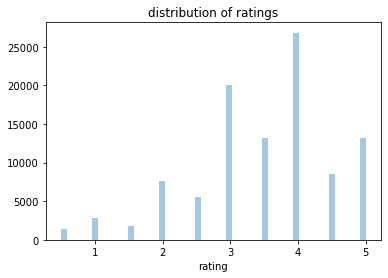

In [65]:
# explore the data

# (1) how many users are there?
print('number of users:', users_data.userId.nunique())

# (2) how many movies are there with at least 1 rating?
print('number of movies:', users_data.movieId.nunique())

# (3) average number of ratings per user
print("average number of ratings per user:", np.round(users_data.groupby("userId").movieId.count().mean(), 1))

# (4) distribution of ratings
sns.distplot(users_data.rating, kde=False).set_title("distribution of ratings")


#### 2.2 Apply SVD to Obtain Factors

Before we can apply SVD to our data, we must transform it into an appropiate format. To do so, we will use the pivot function where the index='userId' so we will have one row for each user, columns='movieId' so we will have one column for each movie and values='ratings' to fill each value in the table. We will use 0 to indicate movies for which the user has not provided a rating. As the average user has rated 165.3 movies, we will expect the majority of the values to be equal to 0.

In [66]:
pivoted_users_df = users_data.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
print("Shape:", pivoted_users_df.shape) #check
pivoted_users_df.head()

Shape: (610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we have many movies that have only been rated by a handful of users, we are going to focus on the 500 most-rated movies. Therefore, we must find the names of the 500 most rated movies and filter to the subset.

In [67]:
# find the names of the 500 most rated movies

movieIds = pivoted_users_df.columns
movieNames = [movies_data[movies_data.movieId == id_]['title'].iloc[0] for id_ in movieIds] # extract movie titles

pivoted_users_df.columns = movieNames
counts = pivoted_users_df.apply(np.count_nonzero, axis=0) # count the number of ratings for each movie
number_ratings_df = pd.DataFrame(counts).reset_index()
number_ratings_df.columns = ['movieName', 'numberRatings']
# get the names of the 500 movies with the most ratings in the df
movieNames_500 = number_ratings_df.sort_values('numberRatings', ascending=False)[0:500].movieName
len(movieNames_500) # check

500

In [68]:
# get the dataframe for these 500 movies only
movies500_ratings = pivoted_users_df[list(movieNames_500)]
movies500_ratings
# we have 501 rows - looks like we may have a duplicate movie? something to keep in mind...

,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,"Ring, The (2002)",Blue Velvet (1986),Beverly Hills Cop (1984),Adaptation (2002),Gran Torino (2008),Lethal Weapon 3 (1992),"Simpsons Movie, The (2007)",Fear and Loathing in Las Vegas (1998),M*A*S*H (a.k.a. MASH) (1970),Rumble in the Bronx (Hont faan kui) (1995)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,3.0,4.0,5.0,5.0,4.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,4.0,3.5,5.0,4.5,5.0,4.5,2.5,3.5,3.5,5.0,...,0.0,0.0,2.5,0.0,4.5,0.5,3.5,4.0,0.0,0.0
607,0.0,5.0,3.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
608,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,4.0,...,4.5,0.0,2.5,4.0,0.0,3.0,0.0,0.0,0.0,0.0


Now that the data is in the proper format, we can apply SVD. We will get three items returned:

1) U:  user-to-concept similarity matrix

2) Σ (sigma): the diagonal elements representing the ‘strength’ of each concept

3) V: movie-to-concept similarity matrix

In this example, we will extract the 50 latent factors with the greatest 'strength' values. 

**Thought exercise**: what do you expect to be the shapes of U, Σ and V?

In [73]:
svd_model = TruncatedSVD(n_components=50, random_state=671) # extract the 50 latent factors with the greatest 'strength' values
users_df_svd = svd_model.fit_transform(movies500_ratings)

U = users_df_svd / svd_model.singular_values_ 
sigma = svd_model.singular_values_
V = svd_model.components_ # principle components

# checks 
print("Shape of U:", U.shape) # (users, factors)
print("Length of Sigma:", len(sigma)) # factors' strength
print("Shape of V:", V.shape) # (factors, movies)

Shape of U: (610, 50)
Length of Sigma: 50
Shape of V: (50, 501)


In [74]:
sigma # in decreasing order, strength

array([466.28305399, 184.2867868 , 150.865238  , 131.66338205,
       112.77223158, 100.5992887 ,  95.23616388,  83.08540223,
        78.52242635,  75.54633709,  71.25520058,  70.63359514,
        67.78623253,  65.22481476,  63.42082116,  61.52909262,
        60.92027447,  60.06398467,  58.57589081,  57.81208473,
        57.18785711,  56.59869891,  55.35335753,  54.97218306,
        54.48476391,  53.03248303,  52.4555775 ,  52.31051957,
        51.94874101,  50.85450336,  50.08743664,  49.78427439,
        49.59281004,  49.04869683,  48.88337675,  48.73557065,
        48.31739718,  47.65066305,  47.28746194,  46.83127264,
        46.07058092,  45.8766972 ,  45.51483049,  45.33611288,
        44.90300899,  44.19204848,  43.93253941,  43.88007922,
        43.2559492 ,  43.2237098 ])

Now that we have decomposed our matrix, one question we may want to answer is: what movies are clustering together? To begin answering this, let's look at some of the latent factors for the movies and see if we can get an idea of what the factors may represent.

In [77]:
V.shape

(50, 501)

In [79]:
V[0].shape # fist-strength factor/component/concept in 501 movies

(501,)

In [80]:
# 1st concept

movie_concept1 = V[0] # the concept with the greatest strength, just the average (not very helpful)
movieNames = movies500_ratings.columns # get a list of the movie names

# TOP movie sets in this feature:
indices = sorted(range(len(movie_concept1)), key=lambda i: movie_concept1[i], reverse=True)[0:20] # get the indices of the movies with the top 20 values
names = [movieNames[ind] for ind in indices] # get the corresponding movies
movies_data[movies_data.title.isin(names)] # get top-featured 20 movies in this feature/concept

# we see lots of classics/popular movies

,movieId,title,genres
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
461,527,Schindler's List (1993),Drama|War
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi


In [82]:
# 2nd concept

movie_concept1 = V[1] # the concept with the 2nd greatest strength
movieNames = movies500_ratings.columns # get a list of the movie names
indices = sorted(range(len(movie_concept1)), key=lambda i: movie_concept1[i], reverse=True)[0:20] # get the indices of the movies with the top 20 values
names = [movieNames[ind] for ind in indices] # get the corresponding movie index
movies_data[movies_data.title.isin(names)] 

# we see lots of action/adventure movies

,movieId,title,genres
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller
3638,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4137,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4427,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
4615,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
4909,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
4935,7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller
5374,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy
5917,33794,Batman Begins (2005),Action|Crime|IMAX


In [83]:
# 5th concept

movie_concept1 = V[4] # the concept with the greatest strength, just the average (not very helpful)
movieNames = movies500_ratings.columns # get a list of the movie names
# TOP movie sets in this feature:
indices = sorted(range(len(movie_concept1)), key=lambda i: movie_concept1[i], reverse=True)[0:20] # get the indices of the movies with the top 20 values
names = [movieNames[ind] for ind in indices] # get the corresponding movies
movies_data[movies_data.title.isin(names)] 

# we see lots of IMAX/fantasy/sci-fi movies

,movieId,title,genres
97,110,Braveheart (1995),Action|Drama|War
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
793,1036,Die Hard (1988),Action|Crime|Thriller
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
902,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
915,1214,Alien (1979),Horror|Sci-Fi


In [84]:
# except genres, can also be years, length.....many features we need to find

As you can see, it is not always exactly clear what the latent factors represent but we can make some hypotheses about why certain movies are being clustered together. Next, we will see how we can use the matrix V to calculate the similarity between movies.

In [85]:
# calculate the similarity 

In [86]:
# transform V into a dataframe with the movie titles as the columns

movie_factors_df = pd.DataFrame(V, columns = movies500_ratings.columns)
movie_factors_df.shape #check

(50, 501)

In [87]:
# calculate the similarity between movies using cosine similarity/distance

movie1 = movie_factors_df['Beauty and the Beast (1991)']
movie2 = movie_factors_df['Aladdin (1992)']
movie3 = movie_factors_df['Godfather, The (1972)']

result = 1 - spatial.distance.cosine(movie1, movie2)
print("Beauty and the Beast vs. Aladdin:", result)

result = 1 - spatial.distance.cosine(movie1, movie3)
print("Beauty and the Beast vs. The Godfather:", result)

result = 1 - spatial.distance.cosine(movie2, movie3)
print("Aladdin Beat vs. The Godfather:", result)

Beauty and the Beast vs. Aladdin: 0.7656124205552753
Beauty and the Beast vs. The Godfather: -0.07519460181611826
Aladdin Beat vs. The Godfather: 0.02308118129563974


As an example, we see that Beauty and the Beast and Aladdin are much more similar to one another than they are to a serious film like the Godfather.

In [88]:
### YOUR CODE: select a few movies of your choice and calculate the similarity between them

#### 2.3 Simple Recommendation System

Lastly, we will see how we can build a simple movie recommendation system using K-means clustering. We will apply this to the user factors matrix we got by applying SVD above. 

In [89]:
# cluster based on user factors - goal is to find similar users

# apply clustering algorithm
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=5, random_state=6).fit_predict(U) # arbitrary choice of k
clustered_users_df = pd.DataFrame(U, index = pivoted_users_df.index)
clustered_users_df['cluster'] = clusters # create new column with cluster membership
print(clustered_users_df.shape) # check
clustered_users_df.head()

(610, 51)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
userId,,,,,,,,,,,,,,,,,,,,,
1,0.060967,-0.049669,0.086686,-0.016600,0.068021,0.020562,-0.013265,0.088610,-0.098992,-0.047332,...,0.069408,-0.204684,-0.085561,-0.080192,-0.054587,0.033642,-0.001872,0.043636,-0.114727,4
2,0.006570,0.019386,-0.019741,0.024234,0.005601,-0.002765,-0.029358,0.050333,0.000672,-0.005970,...,-0.006804,-0.004077,0.009857,-0.012038,-0.028718,0.013529,-0.004208,-0.019175,0.002442,4
3,0.000530,-0.000551,0.001465,-0.000752,0.001374,0.000581,-0.000746,0.001299,0.002050,-0.002149,...,0.006940,-0.001443,-0.000914,-0.003649,0.006738,0.004019,-0.001383,-0.000606,0.000834,4
4,0.032834,-0.019401,0.073165,-0.000809,-0.051159,-0.047946,-0.001098,0.009432,-0.068840,-0.009217,...,-0.034975,-0.090223,0.016357,-0.103425,-0.030385,-0.004158,0.099117,-0.005170,0.018801,0
5,0.014758,-0.051627,-0.038124,0.024852,-0.021672,-0.016630,-0.008088,-0.012298,-0.009231,-0.012460,...,0.008055,-0.023116,0.002949,0.013731,-0.008313,0.015429,-0.011846,0.025856,0.004890,1


In [90]:
# distribution of users among clusters
clustered_users_df.cluster.value_counts()
# see that the majority of users are in cluster 3

4    424
1     89
0     49
3     37
2     11
Name: cluster, dtype: int64

In [46]:
# who are the similar users?

# select a user
user = int(input("Enter a user id: ")) 

cluster_no = int(clustered_users_df[clustered_users_df.index == user].cluster) # get the user's cluster
print("User", user, "belongs to cluster", cluster_no)
similar_users = list(clustered_users_df[clustered_users_df.cluster == cluster_no].index) # find other users in the cluster
print("Number of similar users:", len(similar_users))
print("Similar users:", similar_users)

Enter a user id:  1


User 1 belongs to cluster 4
Number of similar users: 424
Similar users: [1, 2, 3, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 36, 39, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 55, 57, 59, 60, 61, 63, 64, 65, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 91, 92, 95, 96, 97, 98, 100, 101, 103, 108, 110, 113, 115, 116, 118, 119, 122, 123, 124, 125, 127, 128, 129, 131, 132, 135, 137, 138, 139, 141, 143, 144, 146, 147, 149, 152, 153, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 168, 172, 175, 178, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 207, 208, 209, 211, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 230, 231, 232, 233, 234, 236, 237, 238, 239, 241, 244, 245, 246, 248, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 271, 272, 274, 278, 279, 280, 281, 282, 283, 285, 286, 287, 288, 289,

In [91]:
# how has the cluster rated the movies in our dataset?

cluster_df = movies500_ratings.loc[similar_users] # filter to users in cluster
cluster_df[cluster_df == 0] = np.nan # set 0 values to NaN (to not bias calculation of means)
avg_ratings = cluster_df.mean() # get the mean rating for each movie for the cluster
avg_ratings.sample(5) # preview a sample of the mean cluster ratings

Goldfinger (1964)                               3.837209
Crash (2004)                                    3.853659
Eternal Sunshine of the Spotless Mind (2004)    4.173077
Analyze This (1999)                             3.087500
Shutter Island (2010)                           3.989796
dtype: float64

In [93]:
# what are top 10 rated movies for the cluster?

avg_ratings_df = pd.DataFrame(avg_ratings).reset_index()
avg_ratings_df.columns = ['movieName', 'avgClusterRating']
avg_ratings_df.sort_values('avgClusterRating', ascending=False).head(10)

,movieName,avgClusterRating
1,"Shawshank Redemption, The (1994)",4.451220
2,Pulp Fiction (1994),4.358696
143,Dr. Strangelove or: How I Learned to Stop Worr...,4.357143
21,"Godfather, The (1972)",4.319620
72,"Godfather: Part II, The (1974)",4.319048
136,Casablanca (1942),4.315789
190,Rear Window (1954),4.301471
10,Fight Club (1999),4.293956
115,"Departed, The (2006)",4.287356
43,"Dark Knight, The (2008)",4.282609


The above list tells us the 10 movies with the highest average ratings across the cluster's users. However, when we recommend movies to our user, we want to make sure they haven't seen it before, so we must filter those out from our recommendations.

In [95]:
movies500_ratings

,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,"Ring, The (2002)",Blue Velvet (1986),Beverly Hills Cop (1984),Adaptation (2002),Gran Torino (2008),Lethal Weapon 3 (1992),"Simpsons Movie, The (2007)",Fear and Loathing in Las Vegas (1998),M*A*S*H (a.k.a. MASH) (1970),Rumble in the Bronx (Hont faan kui) (1995)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,3.0,4.0,5.0,5.0,4.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,4.0,3.5,5.0,4.5,5.0,4.5,2.5,3.5,3.5,5.0,...,0.0,0.0,2.5,0.0,4.5,0.5,3.5,4.0,0.0,0.0
607,0.0,5.0,3.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
608,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,4.0,...,4.5,0.0,2.5,4.0,0.0,3.0,0.0,0.0,0.0,0.0


In [99]:
# what are top 10 rated movies for the cluster (that our user has not rated previously)?

user_ratings = movies500_ratings[movies500_ratings.index == user] # this user's rating
rated_movies = list(user_ratings.columns[(user_ratings != 0.0).any(axis=0)]) # all the this user rated movies

avg_ratings_df[avg_ratings_df.movieName.isin(rated_movies) == False].sort_values('avgClusterRating', ascending=False).head(10) # pick the unrated movies by this user

,movieName,avgClusterRating
1,"Shawshank Redemption, The (1994)",4.451220
143,Dr. Strangelove or: How I Learned to Stop Worr...,4.357143
21,"Godfather, The (1972)",4.319620
72,"Godfather: Part II, The (1974)",4.319048
136,Casablanca (1942),4.315789
190,Rear Window (1954),4.301471
115,"Departed, The (2006)",4.287356
43,"Dark Knight, The (2008)",4.282609
63,One Flew Over the Cuckoo's Nest (1975),4.277273
345,Chinatown (1974),4.274510
